# Basics of FFT estimators for P1D (new version, without rfft)

This is a toy example, but to make it easier to connect with reality I will try to use units and values similars to what we believe is the real universe. 

We don't need to specify units in this toy example, but I will use values that would roughly correspond to Mpc in a real data analysis.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Define the FFT grid

In [2]:
# number of pixels (powers of two are usually good)
N=2**10
# skewer length
L=500
# pixel width 
dx = L/N
print('dx=',dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.fftfreq(N)*2*np.pi/dx

dx= 0.48828125


In [3]:
print('Nk =',k.shape)
print('Delta k =',k[1],2*np.pi/L)
print('k_Ny = ',-k[N//2],np.pi/dx)

Nk = (1024,)
Delta k = 0.012566370614359173 0.012566370614359173
k_Ny =  6.433981754551897 6.433981754551897


Setup the random number generator

In [4]:
# random seed
seed=1234
# setup random number generator using seed
gen = np.random.default_rng(seed)
# test the random number generator
gen.normal(size=1)

array([-1.60383681])

### Input power spectrum

The power spectrum will deteremine how much structure is there as a funciton of scale

In [5]:
def get_true_p1d(k,P0=1.0,k0=1,kF=10,r_SiIII=20,f_SiIII=0.05):
    """Define here your favorite power spectrum."""

    if np.any(k<0):
        raise ValueError('true_p1d should only receive non-zero values of k')

    # white noise at low-k
    P = P0*np.ones_like(k)

    # small enhancement at low-k
    P *= (1+k/k0)
    
    # suppressed at k0
    P *= 1/(1+(k/k0)**2)

    # further suppressed with a Gaussian at kF=10
    P *= np.exp(-(k/kF)**2)

    # SiIII(1207) contamination
    P *= (1+f_SiIII*np.cos(k*r_SiIII))
    
    return P

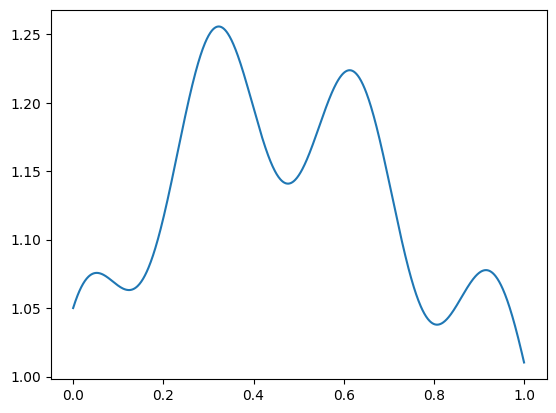

In [6]:
# linear plot
kplot=np.linspace(0,1,1000)
plt.plot(kplot,get_true_p1d(kplot))

(0.0001, 2)

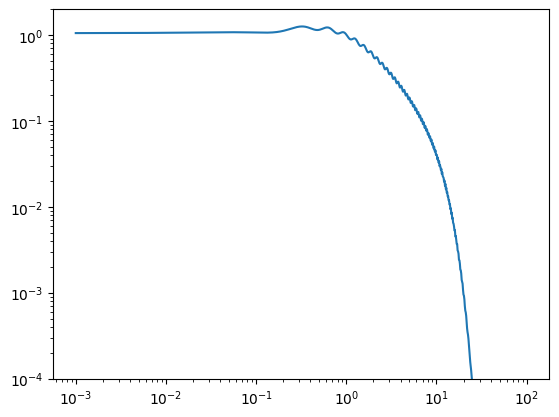

In [7]:
# log spacing plot
kplot=np.logspace(-3,2,1000)
plt.loglog(kplot,get_true_p1d(kplot))
plt.ylim(0.0001,2)

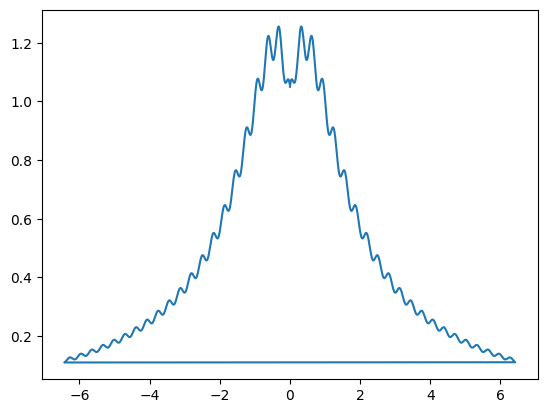

In [8]:
# evaluate true P1D for the plot
true_p1d=get_true_p1d(np.abs(k))
plt.plot(k,true_p1d)

### Generate random Gaussian skewers

Start by generating random Fourier modes

In [9]:
def get_gaussian_modes(gen,new_seed=None,debug=False):
    """Generate Gaussian random numbers for the Fourier modes of the grid."""

    if new_seed:
        new_gen = np.random.default_rng(new_seed)
    else:
        new_gen = gen

    if debug:
        print(new_gen.normal(size=1))
    
    # get power evaluated at each k (with correct normalisation, based on my notes)
    P = get_true_p1d(np.abs(k)) 
    norm = (N/dx)
    P *= norm

    # generate random Fourier modes
    modes = np.empty(N, dtype=complex)
    modes[:].real = new_gen.normal(size=N)
    modes[:].imag = new_gen.normal(size=N)
    
    # normalize to desired power (and enforce real for i=0, i=NF-1)
    modes[0] = modes[0].real * np.sqrt(P[0])
    modes[(N+1)//2] = modes[(N+1)//2].real * np.sqrt(P[(N+1)//2])
    modes[1:(N+1)//2] *= np.sqrt(0.5*P[1:(N+1)//2])    

    # remember that F(-k) = F^*(k)
    modes[(N+1)//2+1:]=np.conj(modes[1:(N+1)//2])[::-1]
    #modes[(N+1)//2+1:] *= np.sqrt(0.5*P[(N+1)//2+1:])    
    
    return modes

In [10]:
modes=get_gaussian_modes(gen,new_seed=1,debug=True)

[0.34558419]


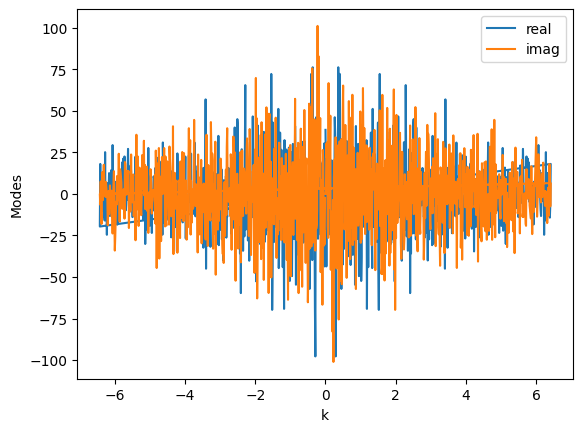

In [11]:
plt.plot(k,modes.real,label='real')
plt.plot(k,modes.imag,label='imag')
plt.xlabel('k')
plt.ylabel('Modes')
#plt.title('Gaussian Fourier modes (real part)')
plt.legend()

### Run on multiple skewers

The squared amplitude of the Fourier modes should (on average!) agree with the input power spectrum

In [12]:
# generate many random fields
Nsk=int(1e6)
gen = np.random.default_rng(seed)

In [13]:
# measure P1D and variance
mean_p1d=np.zeros(N)
var_p1d=np.zeros(N)
for i in tqdm(range(Nsk)):
    modes=get_gaussian_modes(gen=gen,debug=False)
    p1d = abs(modes)**2
    mean_p1d += p1d
    var_p1d += p1d**2
# normalize them
mean_p1d /= Nsk
var_p1d /= Nsk
var_p1d -= mean_p1d**2
# compute error on mean
err_p1d = np.sqrt(var_p1d/Nsk)

100%|██████████████████████████████████| 1000000/1000000 [00:46<00:00, 21562.07it/s]


In [14]:
# correct normalisation based on my notes
mean_p1d *= (dx/N)
err_p1d *= (dx/N)

Text(0.5, 0, 'k')

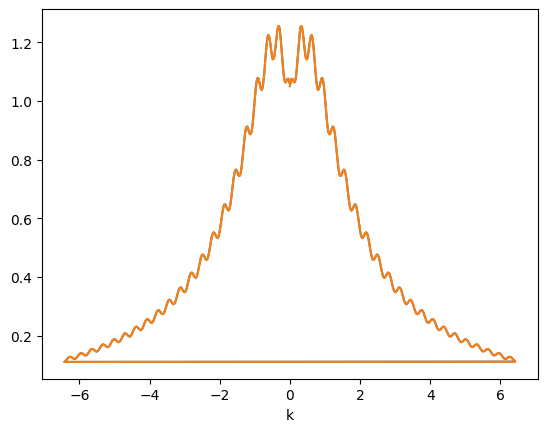

In [15]:
plt.plot(k,mean_p1d)
plt.plot(k,true_p1d)
plt.xlabel('k')

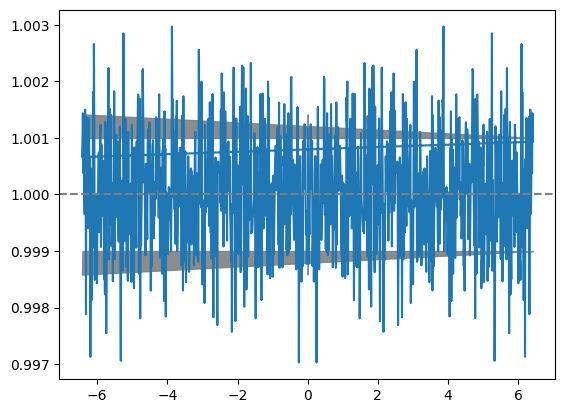

In [16]:
plt.plot(k,mean_p1d/true_p1d)
plt.fill_between(k,1-err_p1d/true_p1d,1+err_p1d/true_p1d,alpha=0.9,color='gray')
plt.axhline(y=1,ls='--',color='gray')

### Test now going back and forth with FFT

In [17]:
def get_gaussian_field(gen,new_seed=None,debug=False):
    """Generate a set of random Fourier modes, and use them to get a field"""
    modes = get_gaussian_modes(gen=gen,new_seed=new_seed,debug=debug)
    deltas = np.fft.ifft(modes).real
    return deltas

In [18]:
modes = modes=get_gaussian_modes(gen=gen,new_seed=seed,debug=True)

[-1.60383681]


In [19]:
delta = np.fft.ifft(modes).real

In [20]:
# Test that we recover the modes
new_modes=np.fft.fft(delta)
print(max(modes-new_modes))

(2.220446049250313e-14+0j)


In [21]:
new_delta=np.fft.ifft(new_modes).real
print(max(delta-new_delta))

8.881784197001252e-16


### Apply a mask (same for all skewers) and redo the plots

In [22]:
mask=np.ones(N)
# will mask a small fraction of the data
Nbad=N//5
mask[Nbad:2*Nbad]=0
mask[6*Nbad:7*Nbad]=0

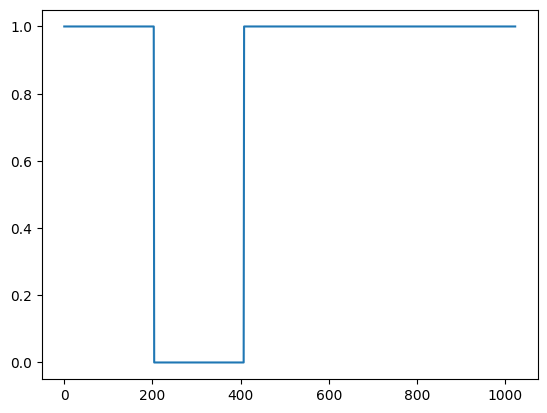

In [23]:
plt.plot(mask)

In [24]:
# FFT the mask, and square it
w_m = np.fft.fft(mask)
w2_m = abs(w_m)**2

(0.0, 0.5)

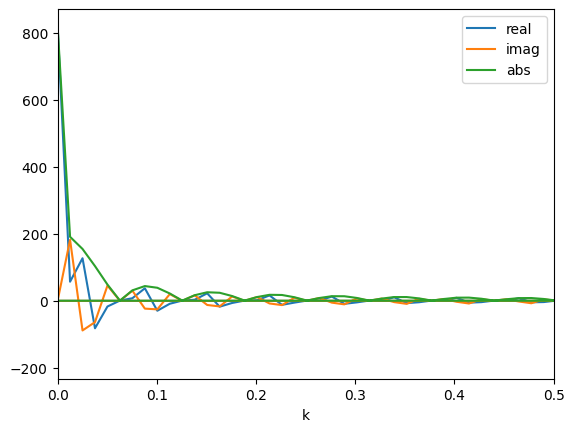

In [25]:
plt.plot(k,w_m.real,label='real')
plt.plot(k,w_m.imag,label='imag')
plt.plot(k,np.sqrt(w2_m),label='abs')
plt.legend()
plt.xlabel('k')
plt.xlim([0,0.5])

In [26]:
# reset seed again
gen = np.random.default_rng(seed)
# measure P1D and variance
mean_masked_p1d=np.zeros(N)
var_masked_p1d=np.zeros(N)
for i in tqdm(range(Nsk)):    
    # recompute modes
    modes=get_gaussian_modes(gen=gen,debug=False)    
    # FFT the modes to obtain the skewers
    deltas = np.fft.ifft(modes).real
    # mask the skewers
    deltas *= mask
    # and FFT again to obtain masked modes
    masked_modes=np.fft.fft(deltas)
    p1d = abs(masked_modes)**2
    mean_masked_p1d += p1d
    var_masked_p1d += p1d**2
# normalize them
mean_masked_p1d /= Nsk
var_masked_p1d /= Nsk
var_masked_p1d -= mean_masked_p1d**2
# compute error on mean
err_masked_p1d = np.sqrt(var_masked_p1d/Nsk)
# correct normalisation based on my notes
mean_masked_p1d *= (dx/N)
err_masked_p1d *= (dx/N)

100%|██████████████████████████████████| 1000000/1000000 [01:00<00:00, 16641.06it/s]


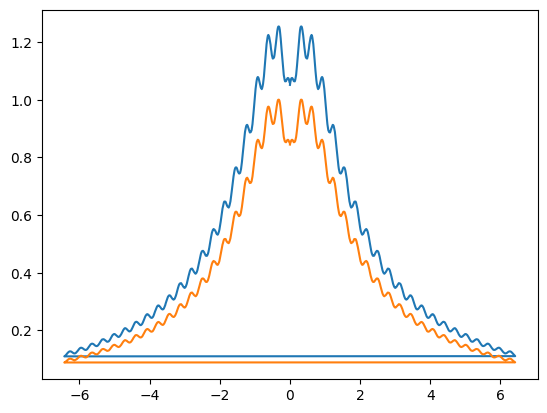

In [27]:
plt.plot(k,mean_p1d)
plt.plot(k,mean_masked_p1d)

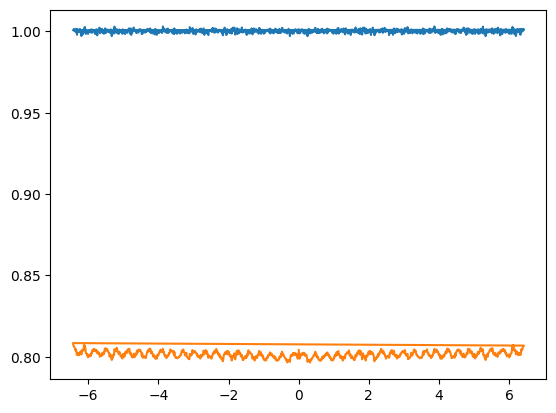

In [28]:
plt.plot(k,mean_p1d/true_p1d)
plt.plot(k,mean_masked_p1d/true_p1d)

In [29]:
norm=np.mean(mean_masked_p1d/mean_p1d)
print(norm)

0.801468480836641


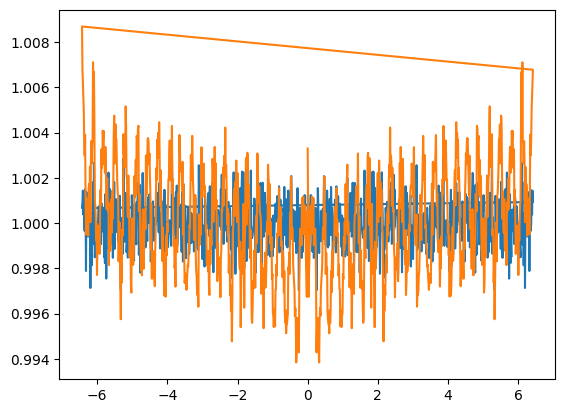

In [30]:
plt.plot(k,mean_p1d/true_p1d)
plt.plot(k,mean_masked_p1d/true_p1d/norm)

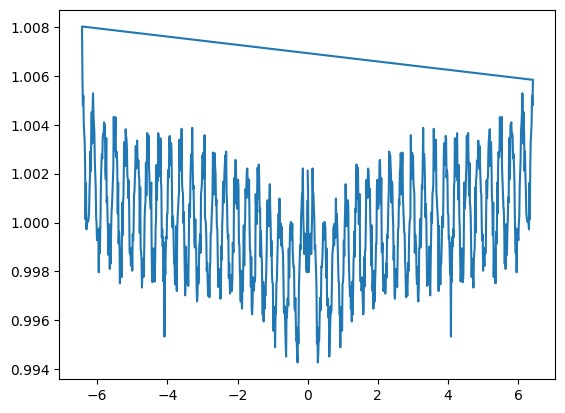

In [31]:
plt.plot(k,mean_masked_p1d/mean_p1d/norm)

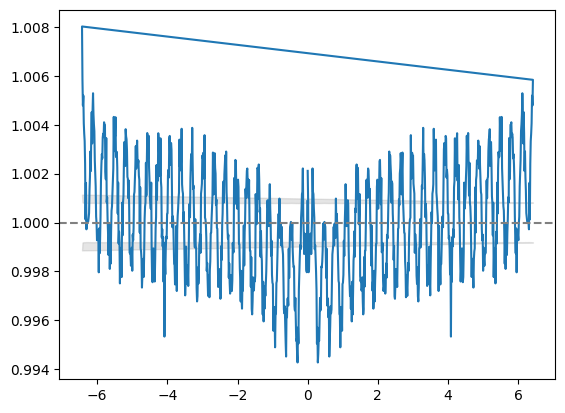

In [32]:
plt.plot(k,mean_masked_p1d/mean_p1d/norm)
plt.fill_between(k,1-err_masked_p1d/true_p1d,1+err_masked_p1d/true_p1d,alpha=0.2,color='gray')
plt.axhline(y=1,ls='--',color='gray')

### Try to convolve theory with mask

In [33]:
convolved_p1d=np.zeros_like(true_p1d)

In [34]:
# slow computation, but clear
for m in range(N):
    for n in range(N):
        if m>= n:
            M_m_n = w2_m[m-n]
        else:
            M_m_n = w2_m[N+m-n]
        convolved_p1d[m] += true_p1d[n] * M_m_n

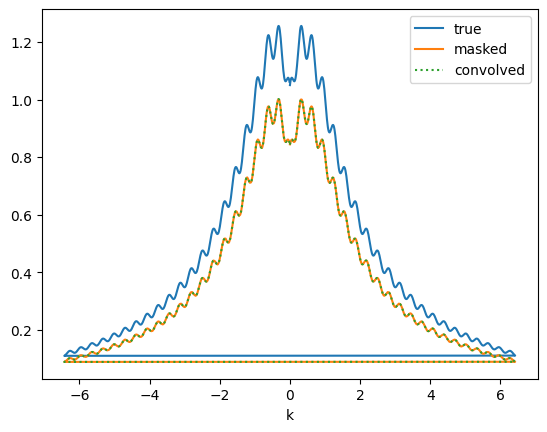

In [35]:
plt.plot(k,true_p1d,label='true')
plt.plot(k,mean_masked_p1d,label='masked')
plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.xlabel('k')
plt.legend()

In [36]:
### Second version, using convolution theory of DFT
P_m = true_p1d / dx # < |delta_m|^2 >
xi_a = np.fft.ifft(P_m)
Q_a = np.fft.ifft(w2_m)
x = dx*np.arange(N)

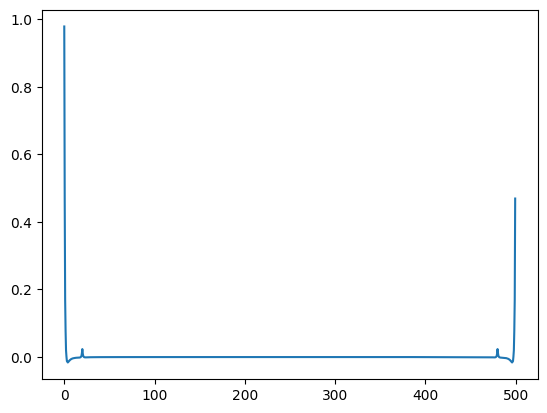

In [37]:
plt.plot(x,xi_a.real)

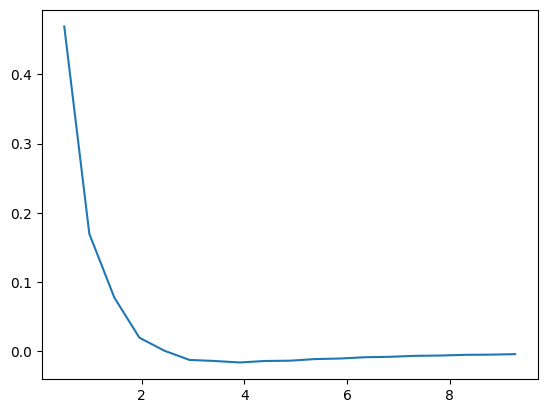

In [38]:
plt.plot(x[1:20],xi_a[1:20].real)

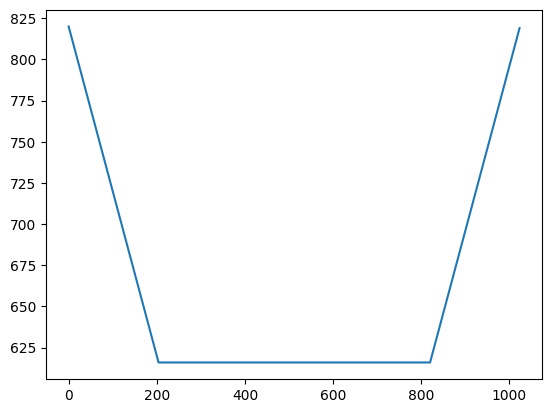

In [39]:
plt.plot(Q_a.real)

In [40]:
T_m = np.fft.fft(Q_a*xi_a)

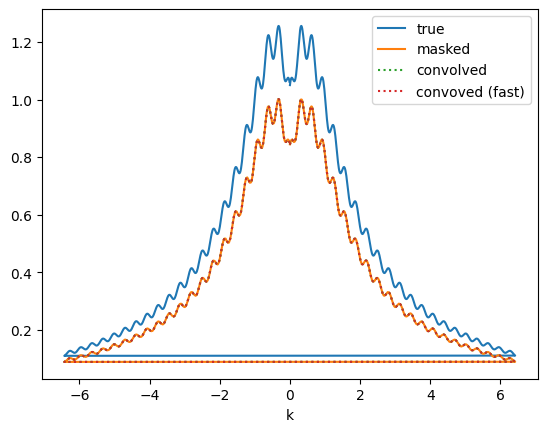

In [41]:
plt.plot(k,true_p1d,label='true')
plt.plot(k,mean_masked_p1d,label='masked')
plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.plot(k,T_m.real*(dx/N),ls=':',label='convoved (fast)')
plt.xlabel('k')
plt.legend()

In [42]:
# these should be identical
np.max(abs(convolved_p1d/L-T_m.real))

5.9117155615240335e-12